In [1]:
import re
import csv
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/keren/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load data

Link to data: https://www.kaggle.com/datasets/ymaricar/cmu-book-summary-dataset/data

In [2]:
DATA_PATH = "./data/booksummaries.txt"

In [3]:
data = []
with open(DATA_PATH, 'r') as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in reader:
        data.append(row)

columns = ['book_id', 'freebase_id', 'book_title', 'author', 'publication_date', 'genre', 'summary']
df = pd.DataFrame.from_records(data, columns=columns)
df.head()

,book_id,freebase_id,book_title,author,publication_date,genre,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [4]:
df.shape

(16559, 7)

In [5]:
df.nunique()

book_id             16559
freebase_id         16559
book_title          16277
author               4715
publication_date     2640
genre                2155
summary             16532
dtype: int64

## Process data

### Columns with IDs

IDs will not be used for creating book recommendation system, so they can be dropped from the dataset.

In [6]:
df.drop(columns=['book_id', 'freebase_id'], inplace=True)

In [7]:
df.head()

,book_title,author,publication_date,genre,summary
0,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


### Book title

Some titles occurs more than one time.

In [8]:
vc = df.book_title.value_counts()
vc[vc > 1]

book_title
Nemesis        6
Outcast        4
Haunted        4
Inferno        4
The Gift       3
              ..
Fury           2
Illusions      2
Plague Ship    2
Sea Change     2
Transit        2
Name: count, Length: 246, dtype: int64

Those are quite common and short titles. We need to check if there are duplicated pairs with the same author and title.

In [9]:
vc = df[["book_title", "author"]].value_counts()
vc[vc > 1]

book_title                      author          
The Keep                        F. Paul Wilson      2
Peter Pan                       J. M. Barrie        2
Ender's Game                    Orson Scott Card    2
Earthlight                      Arthur C. Clarke    2
Genesis                                             2
Killing Time                                        2
Mr. Monk Goes to the Firehouse  Lee Goldberg        2
Wither                                              2
Name: count, dtype: int64

There are 8 examples where book with the same title and author was in the dataset. Duplicated rows are dropped.

In [10]:
df.drop_duplicates(subset=["book_title", "author"], keep="first", inplace=True)
df.shape

(16551, 5)

### Author

In [11]:
df["author"] = df.author.replace('', np.nan)
Markdown(f"There are {sum(df.author.isna())} books without the author in the dataset.")

There are 2379 books without the author in the dataset.

The most popular authors

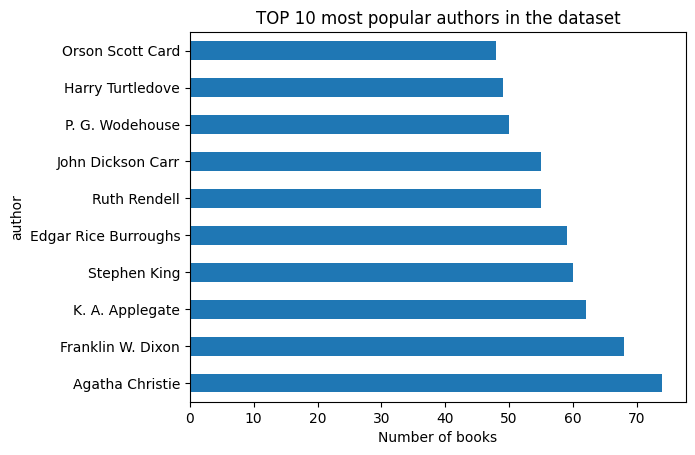

In [12]:
df.author.value_counts().head(10).plot.barh(title="TOP 10 most popular authors in the dataset", xlabel="Number of books")
plt.show()

### Publication date

In [13]:
def get_year_from_date(dates):
    years = []
    for date in dates:
        if date == "":
            years.append(np.nan)
        elif re.search("^\d{4}$", date) is not None:
            years.append(int(date))
        else:
            years.append(int(date.split("-")[0]))
    return years

In [14]:
df["publication_year"] = get_year_from_date(df.publication_date.to_list())

In [15]:
df.publication_year.dropna().describe()

count    10945.000000
mean      1975.920146
std         49.648680
min        398.000000
25%       1966.000000
50%       1991.000000
75%       2003.000000
max       2013.000000
Name: publication_year, dtype: float64

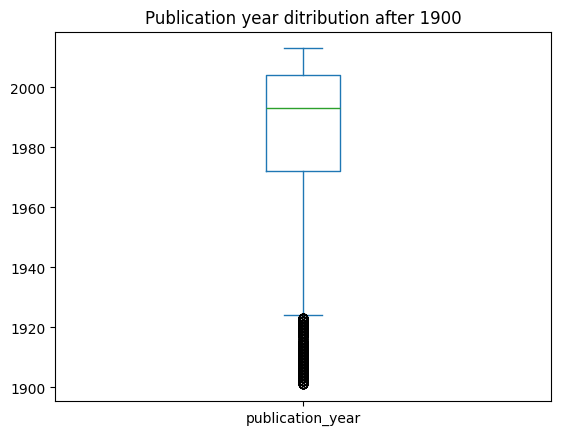

In [16]:
df.query("publication_year > 1900").publication_year.dropna().plot.box(title="Publication year ditribution after 1900")
plt.show()

### Genre

In [17]:
def parse_genre_entry(genre_info):
    if genre_info == '':
        return []
    genre_dict = json.loads(genre_info)
    genres = list(genre_dict.values())
    return genres

In [18]:
df["genre"] = df['genre'].apply(parse_genre_entry)

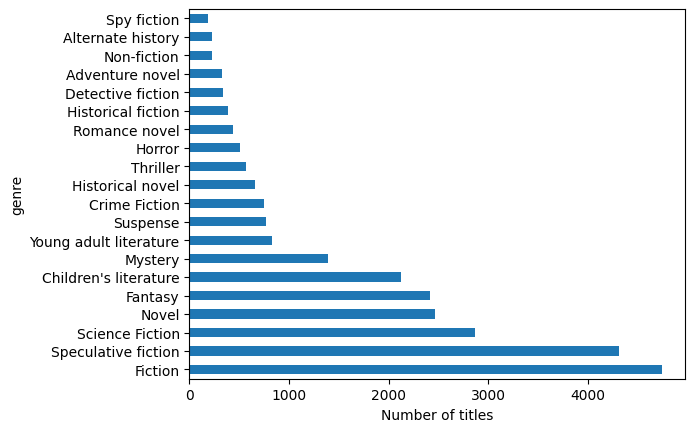

In [19]:
df.genre.explode().dropna().value_counts().head(20).plot.barh(xlabel="Number of titles")
plt.show()

In [20]:
Markdown(f"There are {df.genre.explode().nunique()} unique genre.")

There are 227 unique genre.

### Summary

In [21]:
any(df.summary.isna())

False

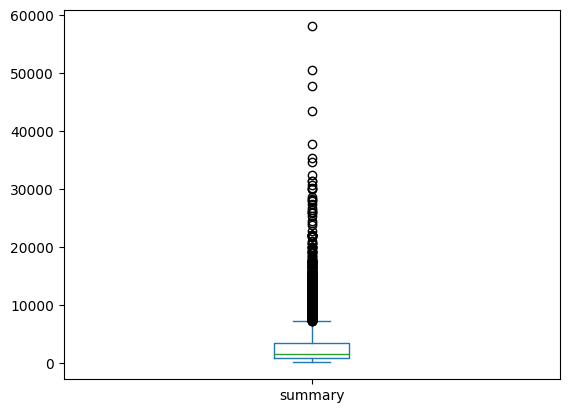

In [22]:
df.summary.apply(len).plot.box()
plt.show()

In [23]:
df.summary.apply(lambda x: len(x.split("."))).describe()

count    16551.000000
mean        21.910096
std         26.000558
min          1.000000
25%          6.000000
50%         13.000000
75%         28.000000
max        507.000000
Name: summary, dtype: float64

In [24]:
def clean_data(list_of_texts: list[str]) -> list[str]:
    clean_text = []
    stopwords_list = stopwords.words("english")
    lem = WordNetLemmatizer()
    for text in list_of_texts:
        new_text = text.lower().strip() # change text to lowercase
        new_text = re.sub('[^a-zA-Z]', ' ', new_text) # remove numbers and special chars
        new_text = re.sub(" +", " ", new_text) # remove repetetive spaces
        new_text = ' '.join(lem.lemmatize(text) for text in new_text.split() if text not in stopwords_list)
        clean_text.append(new_text)
    return clean_text

In [25]:
df["clean_summary"] = clean_data(df.summary.to_list())
df.head()

,book_title,author,publication_date,genre,summary,publication_year,clean_summary
0,Animal Farm,George Orwell,1945-08-17,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca...",1945.0,old major old boar manor farm call animal farm...
1,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan...",1962.0,alex teenager living near future england lead ...
2,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...,1947.0,text plague divided five part town oran thousa...
3,An Enquiry Concerning Human Understanding,David Hume,,[],The argument of the Enquiry proceeds by a ser...,NaN,argument enquiry proceeds series incremental s...
4,A Fire Upon the Deep,Vernor Vinge,,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky ...,NaN,novel posit space around milky way divided con...


## TF-IDF vectorizer

In [26]:
from tfidf_model import TfiDfModel

tfidf = TfiDfModel(df.clean_summary.to_list())
tfidf.calculate_similarity()

In [27]:
idx = 1853
pd.DataFrame(df.loc[idx, ["book_title", "author", "genre", "summary"]])

,1853
book_title,Fevre Dream
author,George R. R. Martin
genre,"[Fantasy, Science Fiction, Speculative fiction..."
summary,"Abner Marsh, a remarkably unattractive but hi..."


In [28]:
recoms = tfidf.get_recommendations(idx)
pd.DataFrame(df.loc[recoms, ["book_title", "author", "genre", "summary"]])

,book_title,author,genre,summary
8022,Mr. Tall,Roger Hargreaves,[Children's literature],Mr. Tall hates his oversized legs. He meets M...
2349,Kaleidoscope Century,John Barnes,"[Science Fiction, Speculative fiction, Fiction]","The narrator, at first appearing to be just o..."
9438,The Fur Country,Jules Verne,"[Fiction, Adventure novel, Novel]",In 1859 Lt. Jasper Hobson and other members o...
10,Book of Joshua,NaN,[],(Chapter 1 is the first of three important mo...
16046,The November Criminals,NaN,[Young adult literature],The hero of the book is 18-year-old Addison S...
390,"Lamb: The Gospel According to Biff, Christ's C...",Christopher Moore,"[Adventure, Absurdist fiction, Speculative fic...",Biff has been resurrected in the present day ...
9639,Matriarch,Karen Traviss,"[Science Fiction, Speculative fiction, Fiction]",Mohan Rayat and Lindsay Neville have been sen...
4374,Hot Sleep,Orson Scott Card,[Science Fiction],"The book follows Jason Worthing, also known a..."
13093,Pale Gray for Guilt,John D. MacDonald,[Mystery],"When McGee visits Tush Bannon, his wife Janin..."
2467,Vampire$,John Steakley,"[Speculative fiction, Fantasy]","The book opens with Vampire$, Inc. cleaning o..."


## Gensim

In [29]:
from doc2vec_model import Doc2VecModel

doc2vec = Doc2VecModel(df.summary.to_list(), 100, 0.025, 4, 20)
doc2vec.calculate_similarity()
doc2vec.save_model("models/d2v.model")

In [30]:
idx = 1853
pd.DataFrame(df.loc[idx, ["book_title", "author", "genre", "summary"]])

,1853
book_title,Fevre Dream
author,George R. R. Martin
genre,"[Fantasy, Science Fiction, Speculative fiction..."
summary,"Abner Marsh, a remarkably unattractive but hi..."


In [31]:
recoms = doc2vec.get_recommendations(idx)
pd.DataFrame(df.loc[recoms, ["book_title", "author", "genre", "summary"]])

,book_title,author,genre,summary
3011,Sandworms of Dune,Kevin J. Anderson,"[Science Fiction, Speculative fiction, Fiction]","As Sandworms of Dune begins, the passengers o..."
662,Lord of Light,Roger Zelazny,"[Science Fiction, Speculative fiction, Fantasy...",Lord of Light is set on a planet colonized by...
3010,Hunters of Dune,Kevin J. Anderson,"[Science Fiction, Speculative fiction, Fiction]","For three years, the no-ship (named the Ithac..."
249,The Return of the King,J. R. R. Tolkien,"[Science Fiction, Biography, Speculative ficti...",Gandalf and Pippin arrive at Minas Tirith in ...
78,The Lord of the Rings,J. R. R. Tolkien,"[Adventure novel, Speculative fiction, Fantasy...","Long before the events of the novel, the Dark..."
15341,Fraulein Spy,NaN,[],The story is set in May 1964. Nick Carter is ...
2415,The Pearls of Lutra,Brian Jacques,"[Children's literature, Fantasy, Speculative f...",When gathering herbs near the quarry in Mossf...
981,Star by Star,Troy Denning,"[Science Fiction, Speculative fiction, Fantasy...",In this dark and dangerous time for the New R...
7540,The Black Unicorn,Terry Brooks,"[Children's literature, Fantasy, Speculative f...","Ben Holiday, court magician Questor Thews and..."
1457,The Unifying Force,James Luceno,"[Science Fiction, Speculative fiction, Fiction]",The novel begins on the Yuuzhan Vong prisoner...


## Sentence Transformer

In [137]:
from transformer_model import TransformerModel

sentence_transformer = TransformerModel(df.summary.to_list(), 'paraphrase-mpnet-base-v2')
sentence_transformer.calculate_similarity()
sentence_transformer.save_model("models/sentence_transformer")

In [138]:
idx = 1853
pd.DataFrame(df.loc[idx, ["book_title", "author", "genre", "summary"]])

,1853
book_title,Fevre Dream
author,George R. R. Martin
genre,"[Fantasy, Science Fiction, Speculative fiction..."
summary,"Abner Marsh, a remarkably unattractive but hi..."


In [139]:
recoms = sentence_transformer.get_recommendations(idx)
pd.DataFrame(df.loc[recoms, ["book_title", "author", "genre", "summary"]])

,book_title,author,genre,summary
4182,The Magic Labyrinth,Philip José Farmer,"[Science Fiction, Speculative fiction, Novel]",The book begins from the point of view of The...
4725,On the Frontiers,Pierre Christin,[],"On a luxury space liner, one of the passenger..."
7857,Stormbreaker: The Graphic Novel,Antony Johnston,[],The story starts off with Alex Rider at Brook...
9438,The Fur Country,Jules Verne,"[Fiction, Adventure novel, Novel]",In 1859 Lt. Jasper Hobson and other members o...
7637,Tilly Witch,NaN,[],Tilly Ipswitch is a witch and the Queen of Ha...
6278,The Boy in the Striped Pyjamas,John Boyne,"[Children's literature, Tragicomedy, Fable, Hi...",Bruno is a 9-year-old boy growing up during W...
5977,Watchers,Dean Koontz,"[Children's literature, Horror, Speculative fi...","The story begins in Santa Barbara, California..."
3442,The Rising,Brian Keene,"[Speculative fiction, Horror, Fiction]",The story starts off in the aftermath of a se...
9431,The Princess Diaries,Meg Cabot,"[Children's literature, Young adult literature...",Mia Thermopolis an average urban ninth grader...
1692,Assassin's Quest,Robin Hobb,"[Speculative fiction, Fantasy]",FitzChivalry Farseer is raised from the dead ...
